In [9]:
import sys
import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine/
print("Running on Computer: [%s]" %myhost)

if myhost=='hoser':
    sys.path.insert(0, '/Users/dbutts/')
    dirname = os.path.join('.', 'checkpoints')
    datadir = '/Users/dbutts/V1/Conway/'
else:
    sys.path.insert(0, '/home/dbutts/Code/')
    datadir = '/home/dbutts/ColorV1/Data/'
    dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 
    
datadir = 'Cdata/'

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets
import NTdatasets.conway.multi_datasets as multidata

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

Running on Computer: [ca1]
Save_dir = /home/dbutts/ColorV1/CLRworkspace/
cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# old data

In [ ]:
fn = 'J220715/J220715_CC_CC_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

data.set_cells(valET)


# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts, num_lags=num_lags)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))
dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')


dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')
LLsNULL = matdat['LLsNULL'][:,0]
LLsGLM = matdat['LLsGLM'][:,0]
LLsGLM2 = matdat['LLsGLM2'][:,0]
drift_terms = matdat['drift_terms']
valET = matdat['cells']
RFcenters = matdat['RFcenters']
#'Gregs': Gopt[:,None], 'XTregs': Xopt
#'top_corner': new_tc[:, None]})
mu0s = utils.pixel2grid(deepcopy(RFcenters[:, [1, 0]]), L=NX)

In [10]:
#expts = ['J220715','J220722','J220801','J220808']
expts = ['J220715']

pdir = datadir+'proc/'
NE = len(expts)
fns = []
for ee in range(NE):
    #fns.append("Jocamo_%s_full_CC_ETCC_nofix_v08"%edates[ee])
    fns.append( "%s/%s_CC_CC_v08"%(expts[ee], expts[ee]) )
    print(ee, expts[ee], ' | ', fns[ee] )

shifts = [None]
metrics = [None]
eLLsNULL = [None]
eLLsGLM = [None]
eLLsGQM = [None]
eRFcenters = [None]
edrifts = [None]
tcs = [None]
cell_lists = [None]

0 J220715  |  J220715/J220715_CC_CC_v08


In [11]:
ee = 0
matdat = sio.loadmat(datadir+"%s/%s_UT_stimpos.mat"%(expts[ee], expts[ee]))
test = np.array(matdat['drift_terms'], dtype=np.float32)
matdat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'LLsNULL', 'LLsGLM', 'drift_terms', 'Dreg', 'RFcenters', 'top_corner', 'valUT', 'NX'])

In [12]:
for ee in range(NE):
    matdat = sio.loadmat(datadir+"%s/%s_UT_stimpos.mat"%(expts[ee], expts[ee]))
    cell_lists[ee] = np.array(matdat['valUT'], dtype=np.int64).squeeze()
    eLLsNULL[ee] = np.array(matdat['LLsNULL'], dtype=np.float32).squeeze()
    eLLsGLM[ee] = np.array(matdat['LLsGLM'], dtype=np.float32).squeeze()
    edrifts[ee] = np.array(matdat['drift_terms'], dtype=np.float32)
    eRFcenters[ee] = np.array(matdat['RFcenters'], dtype=np.int64)
    tcs[ee] = np.array(matdat['top_corner'], dtype=np.int64).squeeze()

    # Shifts
    matdat = sio.loadmat(datadir+"%s/%s_CC_CC_shifts_best.mat"%(expts[ee], expts[ee]))
    shifts[ee] = np.array(matdat['ETshifts'], dtype=np.int64)
    metrics[ee] = np.array(matdat['ETmetrics'], dtype=np.float32).squeeze()

In [13]:
num_lags=16

t0 = time()
mdata = multidata.MultiClouds(
    datadir=datadir, filenames=fns, eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    cell_lists=cell_lists,
    trial_sample=True)
t1 = time()
print("%0.2f sec elapsed"%(t1-t0))

for ee in range(NE):
    DFdat = sio.loadmat(datadir + expts[ee] + '/%s_CC_CC_DFupdate.mat'%expts[ee])
    mdata.updateDF( ee, DFdat['XDF'] )

  FILE_INFO: stim_locsLP list again -- ok but output check
167520 total time steps, 239 units
2.48 sec elapsed


In [14]:
L = 60
for ee in range(1):
    mdata.build_stim( ee, top_corner=tcs[ee], L=L, shifts=shifts[ee] )
mdata.assemble_stim()

  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|██████████████████████████████████████| 34/34 [00:18<00:00,  1.86it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
Stimulus assembly complete


In [15]:
stas = torch.zeros([L**2, mdata.NC])
nspks = torch.zeros(mdata.NC)
bsize = 40
lag = 4
for bb in range(len(mdata.block_inds)//bsize):
    ts =  np.arange(bb*bsize, (bb+1)*bsize)
    Reff = torch.mul(mdata[ts]['robs'], mdata[ts]['dfs'])
    nspks += torch.sum(Reff, axis=0)
    stas += (mdata[ts]['stim'][:-lag, ...].T @ Reff[lag:,:])

stas0 = (stas/nspks).reshape([L,L,mdata.NC]).detach().numpy()
stas0.shape

(60, 60, 174)

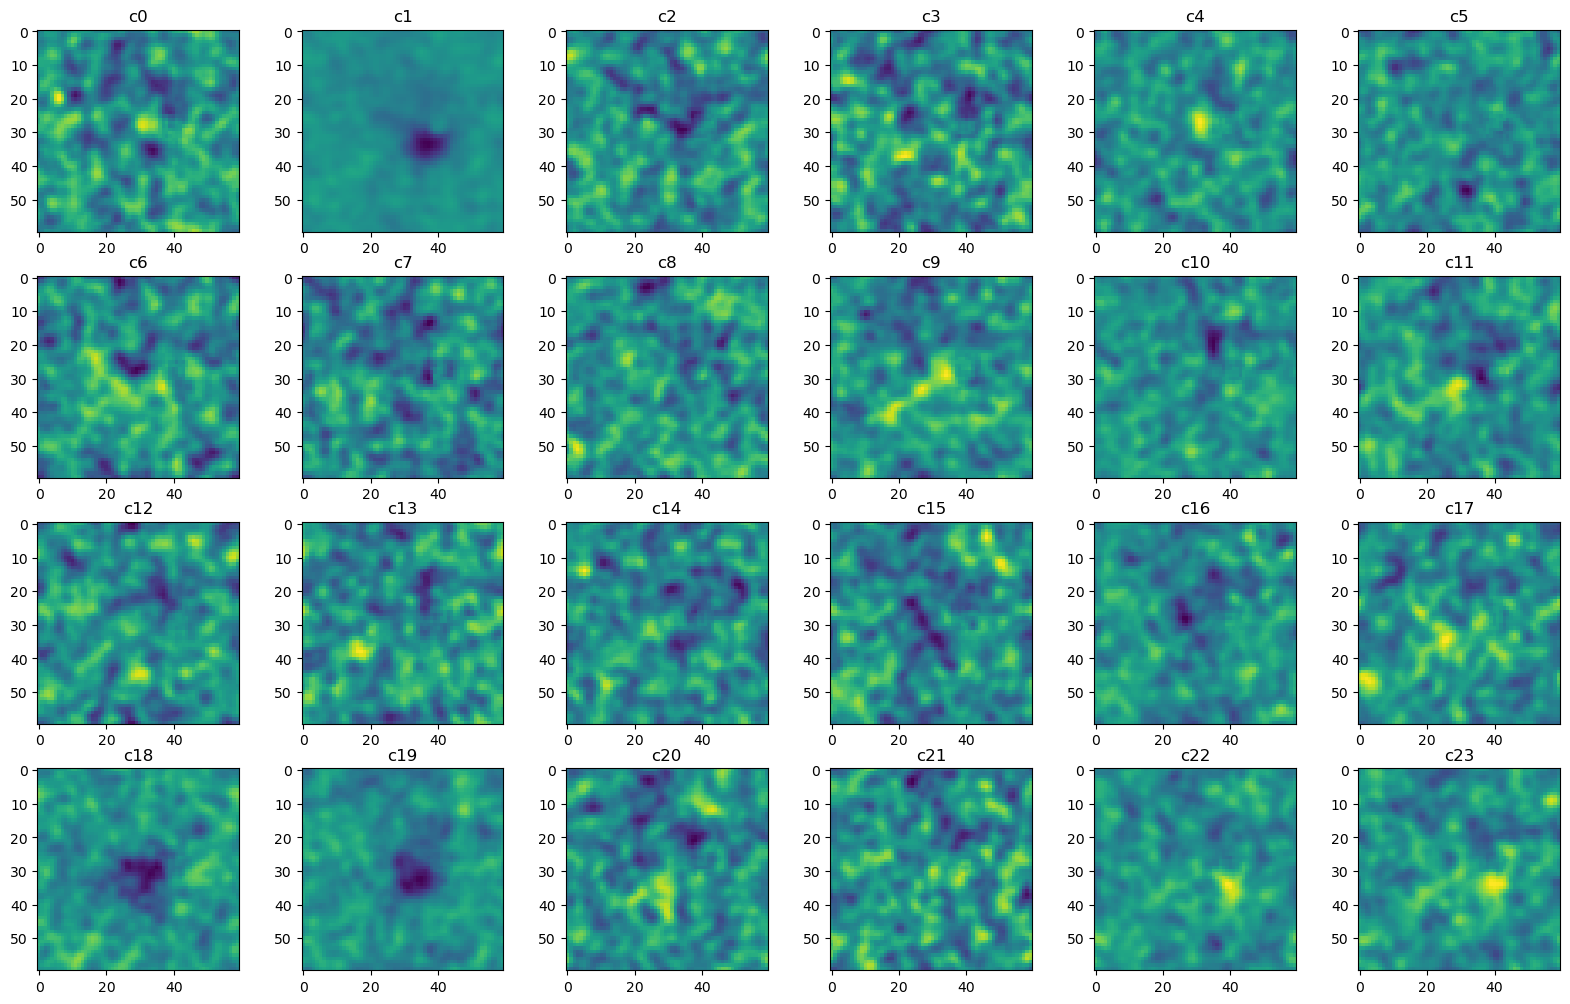

In [16]:
ss(4,6)
for cc in range(24):
    #for clr in range(3):
    plt.subplot(4,6, cc+1)
    imagesc(stas0[:,:,cc])
    plt.title('c%d'%cc)
plt.show()